# Brain Tumor Detection using Transfer Learning

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = [224, 224, 3]
batch_size = 64
train_path = '../input/brain-tumor-classification-mri/Training'
folders = glob(train_path+'/*')
print(folders)
noclasses = len(folders)
print(noclasses)

['../input/brain-tumor-classification-mri/Training/no_tumor', '../input/brain-tumor-classification-mri/Training/pituitary_tumor', '../input/brain-tumor-classification-mri/Training/meningioma_tumor', '../input/brain-tumor-classification-mri/Training/glioma_tumor']
4


In [3]:
for path in folders:
    files = glob(path+'/*')
    print(path, len(files))

../input/brain-tumor-classification-mri/Training/no_tumor 395
../input/brain-tumor-classification-mri/Training/pituitary_tumor 827
../input/brain-tumor-classification-mri/Training/meningioma_tumor 822
../input/brain-tumor-classification-mri/Training/glioma_tumor 826


In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
for i, layer in enumerate(vgg.layers):
    if i<15:
        layer.trainable = False
    
    print(i, layer, layer.trainable)
    

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1dc28287d0> False
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc27e2e50> False
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc1f97fd0> False
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1dc1f41a10> False
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc0012d90> False
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc001d9d0> False
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1dc00180d0> False
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc0026ed0> False
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc002bc50> False
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1dc00330d0> False
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1dc0020e90> False
11 <tensorflow.python.keras.layers.convo

In [6]:
x = Flatten()(vgg.output)
prediction = Dense(noclasses, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(train_path, 
                                              shuffle=True,
                                              target_size = (224,224),
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              subset='training') # set as training data

test_generator = datagen.flow_from_directory(train_path, 
                                             shuffle=False,
                                             target_size = (224,224),
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             subset='validation') # set as validation data

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [26]:
model_history = model.fit(train_generator, 
                          validation_data=test_generator,
                          epochs=25,
                          steps_per_epoch=len(train_generator),
                          validation_steps=len(test_generator),
                          initial_epoch=20)

Epoch 21/25
36/36 [==============================] - 42s 1s/step - loss: 0.0545 - accuracy: 0.9804 - val_loss: 1.0778 - val_accuracy: 0.7801
Epoch 22/25
36/36 [==============================] - 41s 1s/step - loss: 0.0544 - accuracy: 0.9782 - val_loss: 1.0690 - val_accuracy: 0.7749
Epoch 23/25
36/36 [==============================] - 41s 1s/step - loss: 0.0452 - accuracy: 0.9865 - val_loss: 0.9913 - val_accuracy: 0.8010
Epoch 24/25
36/36 [==============================] - 41s 1s/step - loss: 0.0414 - accuracy: 0.9843 - val_loss: 1.0595 - val_accuracy: 0.7941
Epoch 25/25
36/36 [==============================] - 41s 1s/step - loss: 0.0350 - accuracy: 0.9861 - val_loss: 0.9178 - val_accuracy: 0.8150


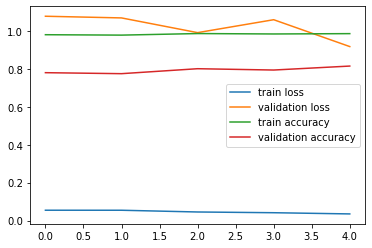

In [27]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [28]:
pred = model.predict(test_generator)

In [29]:
pred = np.argmax(pred, axis=1)

In [30]:
pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3,
       3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1,

In [31]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [32]:
print(accuracy_score(test_generator.labels, pred))
print(f1_score(test_generator.labels, pred,average='weighted'))
print(confusion_matrix(test_generator.labels, pred))

0.8167539267015707
0.8184155734554734
[[129  32   1   3]
 [  4 120   0  40]
 [  0   9  68   2]
 [  0   9   5 151]]


In [25]:
print(accuracy_score(test_generator.labels, pred))
print(f1_score(test_generator.labels, pred,average='weighted'))
print(confusion_matrix(test_generator.labels, pred))

0.8254799301919721
0.8270722271141429
[[139  20   2   4]
 [  5 128   1  30]
 [  1  15  60   3]
 [  1  13   5 146]]


In [ ]:
model.save('VGG16.h5')

## ResNet50

In [45]:
model_name = ResNet50(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

for i, layer in enumerate(model_name.layers):
    if i<165:
        layer.trainable = False
    
    print(i, layer, layer.trainable)
    
x = Flatten()(model_name.output)
prediction = Dense(noclasses, activation='softmax')(x)
model = Model(inputs=model_name.input, outputs=prediction)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1d2ddb50d0> False
1 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1d2c1c2dd0> False
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1d580ad990> False
3 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1d580e4710> False
4 <tensorflow.python.keras.layers.core.Activation object at 0x7f1d2c1c9750> False
5 <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f1d58182a90> False
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1d2c1cda10> False
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1d2c1ce250> False
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1d2c1e76d0> False
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f1d2c1e22d0> False
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1d2c1c8990> False
11 <te

In [46]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
datagen = ImageDataGenerator(rescale=1.0/255, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(train_path, 
                                              shuffle=True,
                                              target_size = (224,224),
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              subset='training') # set as training data

test_generator = datagen.flow_from_directory(train_path, 
                                             shuffle=False,
                                             target_size = (224,224),
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             subset='validation') # set as validation data

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [50]:
model_history = model.fit(train_generator, 
                          validation_data=test_generator,
                          epochs=30,
                          steps_per_epoch=len(train_generator),
                          validation_steps=len(test_generator))

Epoch 1/30
36/36 [==============================] - 42s 1s/step - loss: 2.7566 - accuracy: 0.4284 - val_loss: 83.7432 - val_accuracy: 0.1326
Epoch 2/30
36/36 [==============================] - 41s 1s/step - loss: 1.0326 - accuracy: 0.5620 - val_loss: 24.8549 - val_accuracy: 0.1361
Epoch 3/30
36/36 [==============================] - 41s 1s/step - loss: 1.0416 - accuracy: 0.5599 - val_loss: 7.8531 - val_accuracy: 0.1379
Epoch 4/30
36/36 [==============================] - 41s 1s/step - loss: 0.8745 - accuracy: 0.6295 - val_loss: 2.0858 - val_accuracy: 0.2321
Epoch 5/30
36/36 [==============================] - 40s 1s/step - loss: 0.8204 - accuracy: 0.6539 - val_loss: 1.3160 - val_accuracy: 0.4014
Epoch 6/30
36/36 [==============================] - 41s 1s/step - loss: 0.8245 - accuracy: 0.6526 - val_loss: 1.2635 - val_accuracy: 0.4520
Epoch 7/30
36/36 [==============================] - 41s 1s/step - loss: 0.8713 - accuracy: 0.6482 - val_loss: 1.5926 - val_accuracy: 0.3246
Epoch 8/30
36/36 [

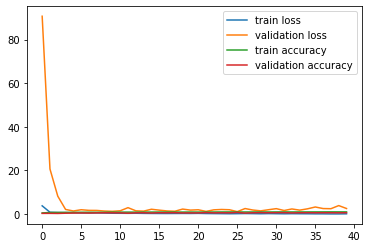

In [41]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

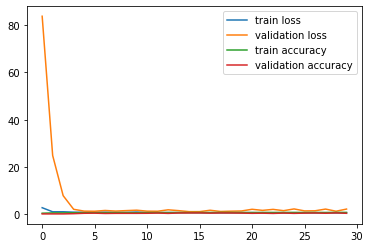

In [51]:
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='validation loss')
plt.plot(model_history.history['accuracy'], label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [52]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,

In [53]:
test_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [44]:
print(accuracy_score(test_generator.labels, pred))
print(f1_score(test_generator.labels, pred,average='weighted'))
print(confusion_matrix(test_generator.labels, pred))

0.5898778359511344
0.5259518023293283
[[ 10 133   6  16]
 [  0 155   1   8]
 [  0   6  72   1]
 [  1  57   6 101]]


In [54]:
print(accuracy_score(test_generator.labels, pred))
print(f1_score(test_generator.labels, pred,average='weighted'))
print(confusion_matrix(test_generator.labels, pred))

0.39790575916230364
0.3393228538566078
[[130  35   0   0]
 [105  58   0   1]
 [ 19  23  37   0]
 [ 73  87   2   3]]


In [ ]:
model.save('ResNet50.h5')